This solution was inspired by the solution developed in:

https://medium.com/coinmonks/celebrity-face-generation-using-gans-tensorflow-implementation-eaa2001eef86


In [16]:
import torch

import torchvision.transforms as transforms
from torchvision.datasets import CelebA
from torch.utils.data import DataLoader, Subset

import torchvision.utils as vutils
import matplotlib.pyplot as plt
import numpy as np

In [5]:
# Device configuration
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
if not torch.cuda.is_available():
    print("WARNING: CUDA not available. Running on CPU.")

How a General Adversarial Network works:

![Alt text](image-1.png)

Pseudocode of GAN:

![Alt text](image.png)

In [6]:
# Setup variables
image_size = 64

In [7]:
# Normalise data
transform_train = transforms.Compose([
    transforms.Resize((image_size, image_size)),
    transforms.ToTensor(),
    transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5))
])

In [11]:
# Create train data
train_data = CelebA(root='C:/Users/Jacqu/Downloads/data/celeba', 
                    split='train', download=False, transform=transform_train)

Create a random subset of data so that we can ensure our model works before moving onto the full dataset:

In [14]:
# Create random indices for train and test datasets
train_indices = torch.randperm(len(train_data))[:1000]

# Create random subset of data
train_subset = Subset(train_data, train_indices)

print(f"Num Train Subset Samples: {len(train_subset)}")

Num Train Subset Samples: 1000


In [15]:
# Setup batch size for train
batch_size = 128

# Create DataLoader for train and test datasets
train_loader = DataLoader(train_subset, batch_size=batch_size, shuffle=True)

To make sure this worked, let's show a random set of images from the dataloader:

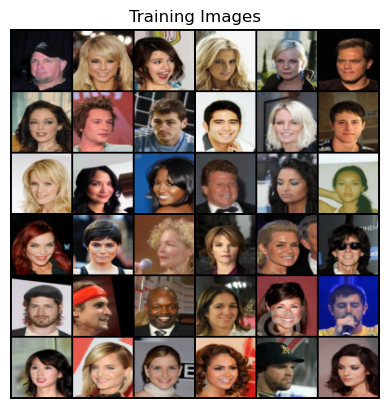

In [18]:
# Get a random batch of images
sample_batch = next(iter(train_loader))

# Make grid from the batch and normalise the images
# Need to permute since PyTorch tensors assume image channel is first dimensions
# but matplotlib assumes it is the third dimension
grid = vutils.make_grid(sample_batch[0][:36], normalize=True, nrow=6).permute(1,2,0)

plt.axis("off")
plt.title("Training Images")

# Convert to numpy array and plot
plt.imshow(np.array(grid))